In [1]:
#%reset

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# import libraries and data

In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

print("train.shape:", train.shape)
print("test.shape:", test.shape)

df_all = pd.concat([train, test], axis=0)
print('df_all.shape', df_all.shape)

train.shape: (1460, 81)
test.shape: (1459, 80)
df_all.shape (2919, 81)


In [4]:
import xgboost as xgb
# from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

1. check if contains duplicates
2. check data types
3. check null values

#### data formatting

Format data types into appropriate ones.

In [5]:
# find out categorical and numerical columns
cat_cols = list(train.dtypes[train.dtypes == 'object'].index)
num_cols = list(train.dtypes[train.dtypes != 'object'].index)

print('cat_cols:', cat_cols)
print('\nnum_cols:', num_cols)

cat_cols: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

num_cols: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeck

In [6]:
# convert to string first for ease of preprocessing
# to be converted back to numbers before encoding
train.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']] = train.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']].astype(str)
test.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']] = test.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']].astype(str)

# assign new cat_cols and num_cols again
cat_cols = list(train.dtypes[train.dtypes == 'object'].index)
num_cols = list(train.dtypes[train.dtypes != 'object'].index)

In [7]:
print('cat_cols:', cat_cols)
print('\nnum_cols:', num_cols)

cat_cols: ['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

num_cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'Ga

#### check duplicates

In [8]:
# check if contains duplicates
train[train.duplicated(subset=['Id']) == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


#### check null values

If more than half are null values, columns are dropped. <br>
If less than half, categorical features are imputed with mode, numerical features are imputed with mean. 

In [9]:
# check null values
print('Null values in categorical columns:')
cat_na = train[cat_cols].isnull().sum()[train[cat_cols].isnull().sum() > 0]
print(cat_na)

print('\nNull values in numerical columns:')
num_na = train[num_cols].isnull().sum()[train[num_cols].isnull().sum() > 0]
print(num_na)

Null values in categorical columns:
Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Null values in numerical columns:
LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [10]:
# drop columns with too many null values 
cols_to_drop = [i for (i, v) in zip(cat_na.index, cat_na.values) if v/len(train) > 0.5]
train.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

In [11]:
# for train data, fill cat_cols with mode; num_cols with mean
for i in [ i for i in cat_na.index if i not in cols_to_drop]:
    train.loc[:, [i]] = train.loc[:, [i]].fillna("NONE")

for i in num_na.index:
    train.loc[:, [i]] = train.loc[:, [i]].fillna(train[i].mean())

In [12]:
# train data cleaned
train.isnull().sum()[train.isnull().sum() > 0]

Series([], dtype: int64)

In [13]:
test_cat_na = test.select_dtypes(include = 'object').isnull().sum()[test.select_dtypes(include = 'object').isnull().sum() > 0]
test_num_na = test.select_dtypes(exclude = 'object').isnull().sum()[test.select_dtypes(exclude = 'object').isnull().sum() > 0]

# for test data, fill cols with train mode / mean
for i in [ i for i in test_cat_na.index]:
    test.loc[:, [i]] = test.loc[:, [i]].fillna(train[i].mode()[0])

for i in test_num_na.index:
    test.loc[:, [i]] = test.loc[:, [i]].fillna(train[i].mean())

In [14]:
# test data cleaned
train.isnull().sum()[train.isnull().sum() > 0]
test.isnull().sum()[test.isnull().sum() > 0]

Series([], dtype: int64)

# Preprocessing

1. remove outliers for important features
2. Feature engineering / generation
3. Normalize numerical data (handling heterokedascity for linear models) 
4. encode data

####  Remove outliers of important features

1. Find out important features (with correlation or information gain)
2. Check if there is any outliers to remove (rely on intuition lol)

In [15]:
# find important features
#correlation matrix
corrmat = train.corr()

# find the features that have greatest correlation with 'SalePrice' 
top_10 = corrmat['SalePrice'].sort_values(ascending=False)[0:11]
top_10


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
MasVnrArea      0.475241
GarageYrBlt     0.470177
Name: SalePrice, dtype: float64

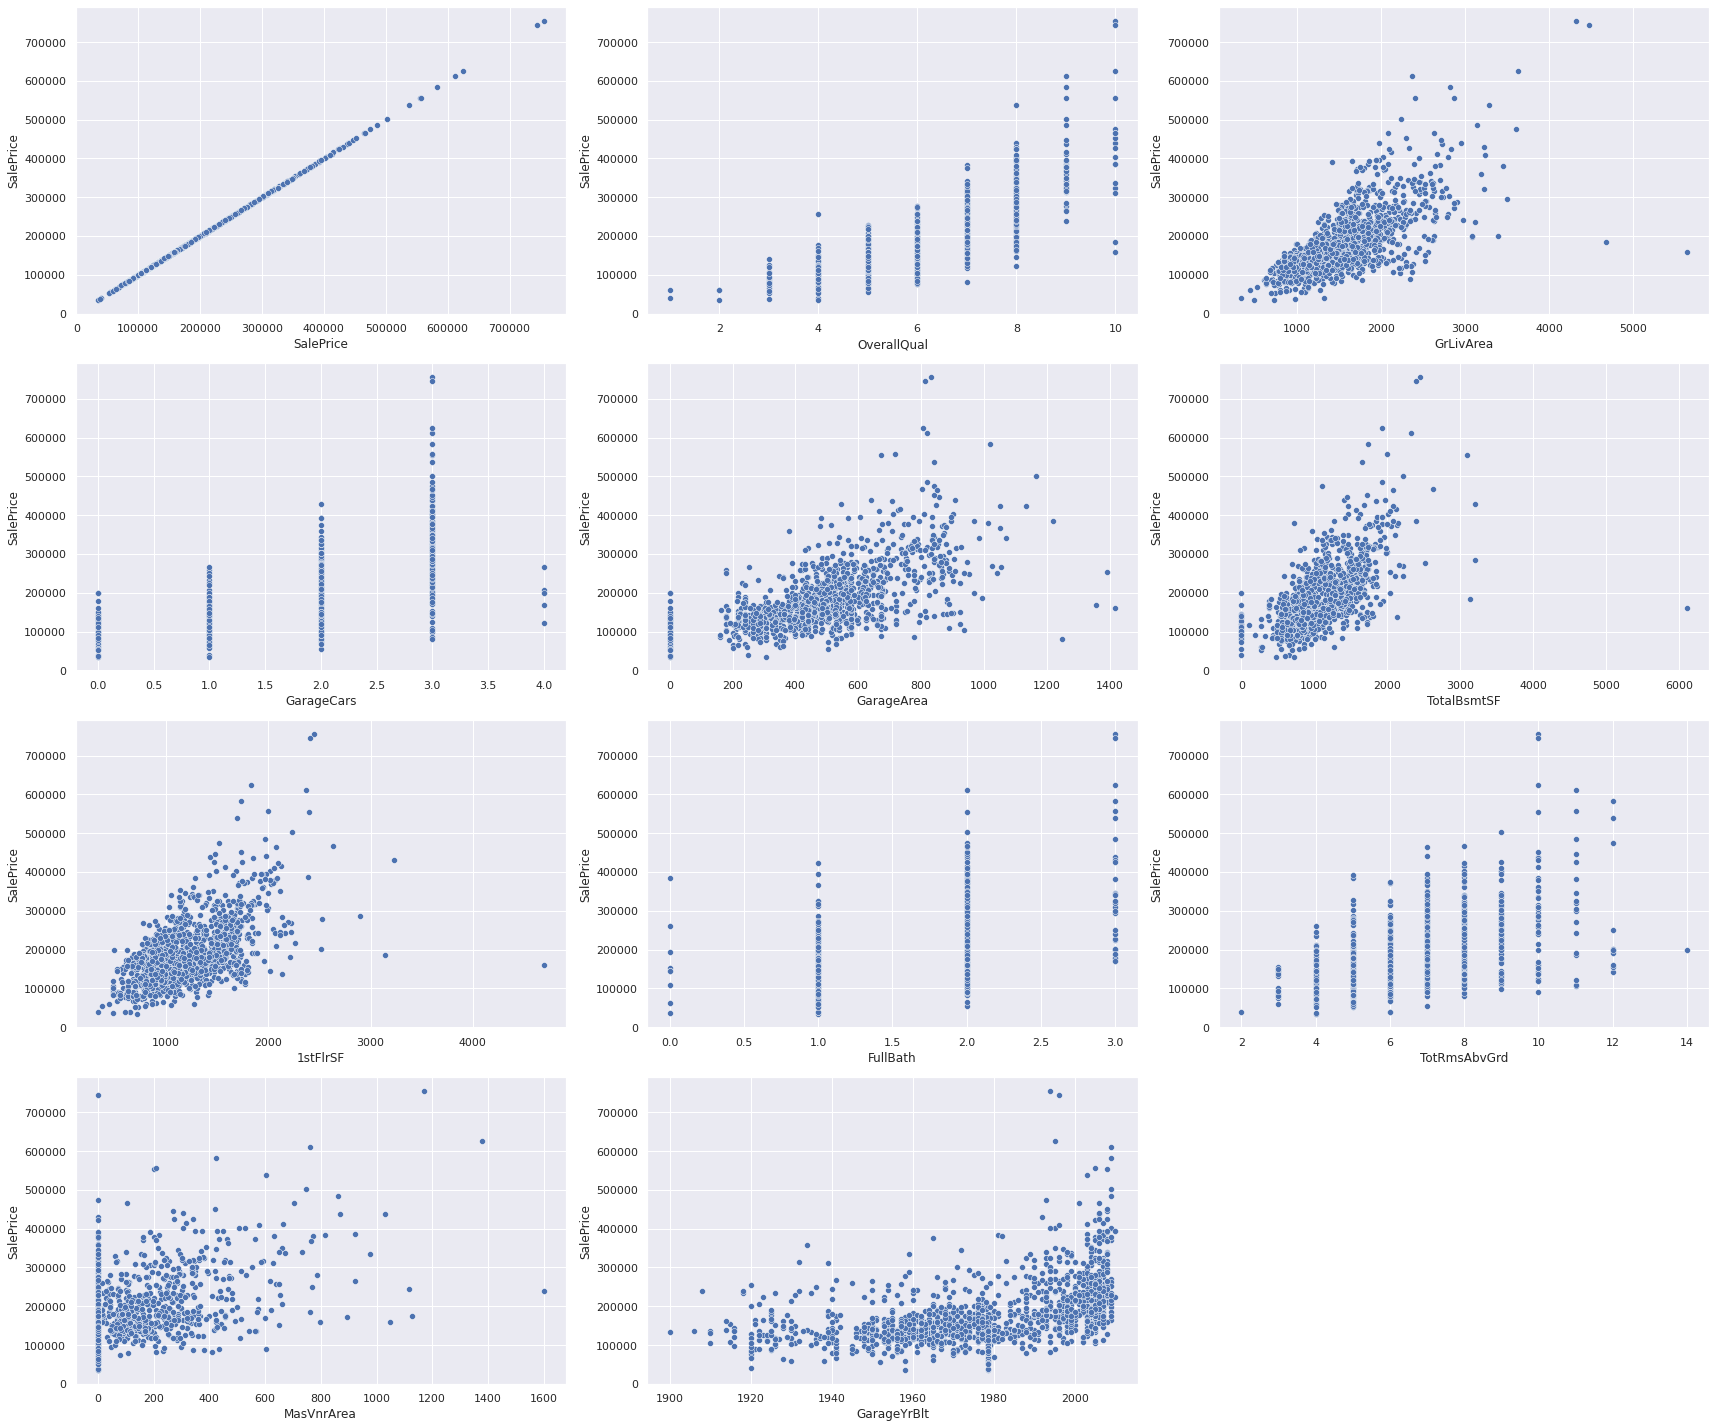

In [16]:
# checking out relationship between features and saleprice
sns.set(rc={'figure.figsize':(24,20)})

for i, column in enumerate(list(top_10.index), 1):
    plt.subplot(4,3,i)
    p=sns.scatterplot(x=column, y='SalePrice', data=train)
    
plt.tight_layout()

In [17]:
# remove the outliers
train = train.drop(train[train.GrLivArea > 4500].index, axis=0, inplace=False)
train = train.drop(train[train.TotalBsmtSF > 6000].index, axis=0, inplace=False)
train = train.drop(train[train['1stFlrSF'] > 4000].index, axis=0, inplace=False)

In [18]:
# location and macro site

#### Feature engineering

Based on domain knowledge. Make good use of interactions between features such as ratio, multiplication, adding things up,...

**What are the most important things in real estate price?** <br>

1. Location, location, location. 
2. Size of property
    - indoor area
    - outdoor area
    - ground floor area
3. Type of property (commercial or residential or industrial)
    - how many storeys?  
    - has basement?
4. conveneince: infrastructre nearby
5. Condition of the house


In [19]:
print(cat_cols)

['Id', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [20]:
print(num_cols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']


In [21]:
def feature_extract(df):
    
    # location, location, location
    # types of housing
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['MSZoning_SubClass'] = df['MSSubClass'] + '_' + df['MSZoning']
    df['Neighborhood_BldgType'] = df['Neighborhood'] + '_'+ df['BldgType']
    df['Neighborhood_HouseStyle'] = df['Neighborhood'] + '_' + df['HouseStyle']
    df['Neighborhood_MSSubClass'] = df['Neighborhood'] + '_'+ df['MSSubClass']
    df['Neighborhood_MSZoning'] = df['Neighborhood'] + '_' + df['MSZoning']
    df['Neighborhood_LotConfig'] = df['Neighborhood'] + '_' + df['LotConfig']
    df['MSZoning_Condition1'] = df['MSZoning'] + '_' + df['Condition1']
    df['MSZoning_Condition2'] = df['MSZoning'] + '_' + df['Condition2']
    
    # size based on neighborhood, house type, zoning
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Neighborhood_median_SF'] = df.groupby('Neighborhood')['TotalSF'].transform(lambda x: x.median())
    return df

In [22]:
train = feature_extract(train)
test = feature_extract(test)

In [23]:
def num_feature_engineering_pipeline(num_features):
    
    # indoor size
    num_features['Total_sqr_footage'] = (num_features['BsmtFinSF1'] + num_features['BsmtFinSF2'] +
                                     num_features['1stFlrSF'] + num_features['2ndFlrSF'])
    num_features['TotalSF'] = num_features['TotalBsmtSF'] + num_features['1stFlrSF'] + num_features['2ndFlrSF']
    
    # indoor features
    num_features['Total_Bathrooms'] = (num_features['FullBath'] + (0.5 * num_features['HalfBath']) +
                                   num_features['BsmtFullBath'] + (0.5 * num_features['BsmtHalfBath']))
    num_features['has2ndfloor'] = num_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    num_features['hasbsmt'] = num_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    num_features['hasfireplace'] = num_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    # outdoor features (binary)
    num_features['haspool'] = num_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    num_features['HasWoodDeck'] = (num_features['WoodDeckSF'] == 0) * 1
    num_features['HasOpenPorch'] = (num_features['OpenPorchSF'] == 0) * 1
    num_features['HasEnclosedPorch'] = (num_features['EnclosedPorch'] == 0) * 1
    num_features['Has3SsnPorch'] = (num_features['3SsnPorch'] == 0) * 1
    num_features['HasScreenPorch'] = (num_features['ScreenPorch'] == 0) * 1
    num_features['hasgarage'] = num_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    num_features['Total_porch_sf'] = (num_features['OpenPorchSF'] + num_features['3SsnPorch'] +
                                  num_features['EnclosedPorch'] + num_features['ScreenPorch'] +
                                  num_features['WoodDeckSF'])
    # quality
    num_features['Total_Home_Quality'] = num_features['OverallQual'] + num_features['OverallCond']
    
    # year    
    num_features['YearsSinceRemodel'] = num_features['YrSold'].astype(int) - num_features['YearRemodAdd'].astype(int)
    num_features['YearBuilt'] = num_features['YrSold'].astype(int) - num_features['YearBuilt'].astype(int)
    
    '''
    num_features['TotalBsmtSF'] = num_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    num_features['2ndFlrSF'] = num_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    num_features['GarageArea'] = num_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    num_features['GarageCars'] = num_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    num_features['LotFrontage'] = num_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    num_features['MasVnrArea'] = num_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    num_features['BsmtFinSF1'] = num_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    '''
    return num_features

In [24]:
train = num_feature_engineering_pipeline(train)
test = num_feature_engineering_pipeline(test)

#### Normalize features

Important for any kind of linear model. As we will be ensembling models later, this become an essential preprocessing step to do. <br>
**Note**: 
1. features to be normalized should be modelled by training data only without involving test data at all. 
2. it is essential to make sure consistent transformation happen across training data and test data. If columns ['a','b','c'] are normalized in training data, the same columns are to be normalized in test data regardless how its distribution. 

Steps:
1. Normalize target features
2. Normalize all other features (usually use box-cox transformation of `scipy` package

#### Normalize target features

If target features are highlt skewed, apply normalization method. 

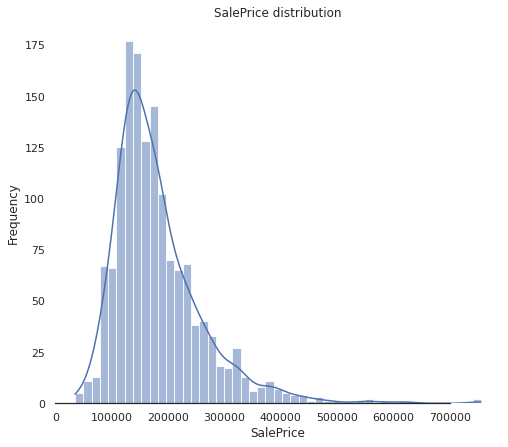

In [25]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(train['SalePrice'], color="b", kde=True);
# set labels
ax.set(ylabel="Frequency"); ax.set(xlabel="SalePrice"); ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

Apparently, the target feature is highly right skewed. So, normalization is applied. 

In [26]:
# transform target feature with log1p, i.e. log(x+1) +1 to prevent error caused by log(0)
train['log1p_SalePrice'] = np.log1p(train.SalePrice)

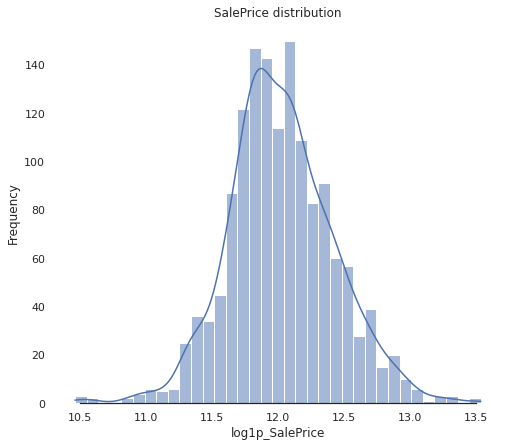

In [27]:
# vsualise transformed target feature
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.histplot(train['log1p_SalePrice'], color="b", kde=True);
# set labels
ax.set(ylabel="Frequency"); ax.set(xlabel="log1p_SalePrice"); ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

#### normalize all other features with skewness > 0.75

Find out these highly skewed data and apply box-cox transfomation. <br>
**Note**: Though I dont know the exact maths, the train and test data needs to be normalized together, else it will return terrible results. 

In [28]:
# separate features and target
X_train = train.drop(['SalePrice','log1p_SalePrice'], axis=1).reset_index(drop=True)
y_train = train.loc[:, 'log1p_SalePrice'].reset_index(drop=True)

X_test = test.copy()

In [29]:
all_data = pd.concat([X_train, X_test], axis=0)
all_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,haspool,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,hasgarage,Total_porch_sf,Total_Home_Quality,YearsSinceRemodel
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,1,0,1,1,1,1,61,12,5
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,1,1,1,1,1,298,14,31
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,1,0,1,1,1,1,42,12,6
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,1,0,0,1,1,1,307,12,36
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,1,1,1,1,276,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,1,1,1,1,1,0,0,11,36
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,1,0,1,1,1,1,24,9,36
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,1,1,1,1,1,474,12,10
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,1,1,1,0,112,10,14


In [30]:
# handling skewness in other features
# code from SERIGNE
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# combine to apply transformation to both train and test data separately

# Check the skew of all numerical features
all_trained_skewed_feats = all_data.select_dtypes(exclude='object').apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
trained_skewed_feats = all_trained_skewed_feats[all_trained_skewed_feats > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(trained_skewed_feats.shape[0]))

There are 24 skewed numerical features to Box Cox transform


Apply box-ccox transformation. <br>

I tried to comment out the box-cox transformation, realise that the performance becomes much worse. So it is absolutely needed. 

In [31]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
skewed_features = trained_skewed_feats.index
lambda_ = 0.15 # how to determine suitable lambda for box-cox transformaton?
for feat in skewed_features:
    lambda_ = boxcox_normmax(all_data[feat] + 1)
    all_data[feat] = boxcox1p(all_data[feat], lambda_)

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [32]:
skewness_after_boxcox = train.select_dtypes(exclude='object').apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
still_big_skewness = skewness_after_boxcox[skewness_after_boxcox > 0.75]

print(f'{len(still_big_skewness)} features still have skewness > 0.75.')
still_big_skewness # just leave them be

25 features still have skewness > 0.75.


MiscVal                   24.434913
PoolArea                  15.932532
haspool                   15.492067
LotArea                   12.560986
3SsnPorch                 10.286510
LowQualFinSF               8.995688
KitchenAbvGr               4.480268
BsmtFinSF2                 4.247550
ScreenPorch                4.114690
BsmtHalfBath               4.095895
EnclosedPorch              3.083987
MasVnrArea                 2.692313
OpenPorchSF                2.337421
SalePrice                  1.879360
LotFrontage                1.692976
WoodDeckSF                 1.544214
Total_porch_sf             1.103269
Total_sqr_footage          1.019762
GrLivArea                  1.009951
BsmtUnfSF                  0.919955
1stFlrSF                   0.886723
2ndFlrSF                   0.812121
Neighborhood_median_SF     0.808409
TotalSF                    0.803494
BsmtFinSF1                 0.764002
dtype: float64

In [33]:
# if input feature is constant or negative or too close to 0, 
# the transformation might return null values sometimes, 
# so check and decides to drop feature from transformation or impute
all_data.isnull().sum()[all_data.isnull().sum() > 0]

Series([], dtype: int64)

#### encoding data

Establish two encoding pipelines. <br>
- For tree-based models, use `LabelEncoding`. <br>
- For linear models, use `BinaryEncoding`.

for all preprocessing including encoding, train and test are supposed to be separated. But I am lazy to do the transformation at the moment because there are some inconsistencies in train and test data. Will fix this later. 

In [34]:
# converting these features back to int before label encoding
all_data.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']] = all_data.loc[:, ['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold', 'Id']].astype(int)

In [35]:
all_data_tree = all_data.copy()
all_data_linear = all_data.copy()

In [36]:
# for baseline, just labelencode whole thing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in all_data.select_dtypes('object').columns:
    le.fit(all_data.loc[:, i].values)
    all_data_tree.loc[:, i] =le.transform(all_data_tree.loc[:, i])

In [37]:
# binary encode for linear models
from category_encoders.binary import BinaryEncoder
be = BinaryEncoder()

all_data_linear = be.fit_transform(all_data_linear)

In [38]:
all_data_linear

,Id,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSZoning_0,MSZoning_1,MSZoning_2,LotFrontage,...,haspool,HasWoodDeck,HasOpenPorch,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch,hasgarage,Total_porch_sf,Total_Home_Quality,YearsSinceRemodel
0,1,0,0,0,0,1,0,0,1,17.139553,...,0.0,1,0,1,1,1,1,18.736118,12,5
1,2,0,0,0,1,0,0,0,1,19.461575,...,0.0,0,1,1,1,1,1,51.635462,14,31
2,3,0,0,0,0,1,0,0,1,17.620960,...,0.0,1,0,1,1,1,1,14.654640,12,6
3,4,0,0,0,1,1,0,0,1,16.315541,...,0.0,1,0,0,1,1,1,52.609466,12,36
4,5,0,0,0,0,1,0,0,1,20.048332,...,0.0,0,0,1,1,1,1,49.205234,13,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,0,1,1,0,0,0,1,0,8.389121,...,0.0,1,1,1,1,1,0,0.000000,11,36
1455,2916,0,1,1,0,0,0,1,0,8.389121,...,0.0,1,0,1,1,1,1,10.059916,9,36
1456,2917,0,0,0,1,0,0,0,1,29.542208,...,0.0,0,1,1,1,1,1,69.046249,12,10
1457,2918,0,1,0,1,0,0,0,1,16.648542,...,0.0,0,0,1,1,1,0,27.761293,10,14


In [39]:
X_train_tree = all_data_tree.loc[all_data.Id < 1461, :].reset_index(drop=True)
X_test_tree = all_data_tree.loc[all_data.Id >= 1461, :].reset_index(drop=True)

X_train_linear = all_data_linear.loc[all_data.Id < 1461, :].reset_index(drop=True)
X_test_linear = all_data_linear.loc[all_data.Id >= 1461, :].reset_index(drop=True)

#### kfold split

assign kfold at first can come in handy c/w just using `cross_val_score` at the end, e.g. target encoding. 

In [40]:
def kf_split(df):
    # creaete kfold column and initialize with -1
    df['kfold'] = -1

    # initiate kfold class from model selection module
    kf = KFold(n_splits=5)

    # fill the new kfold column
    for fold, (train_, valid_) in enumerate(kf.split(X=train)):
        df.loc[valid_, 'kfold'] = fold
        
    return df

X_train_tree = kf_split(X_train_tree)
X_train_linear = kf_split(X_train_linear)

# Models

In [41]:
def cv_rmse(model, folds, X=X_train_tree, y = y_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=folds))
    return (rmse)

In [42]:
### first, use xgboost as baseline
xg = xgb.XGBRegressor(random_state=42, n_estimators = 1200, learning_rate=0.1, max_depth=3, reg_lambda =0.5, n_jobs = 4)

xg_score = cv_rmse(xg, folds=5)
print('cv score:', xg_score)
print('mean cv score:', '%.3f'% xg_score.mean())

cv score: [0.11008085 0.12231261 0.12410469 0.10924251 0.12448236]
mean cv score: 0.118


In [43]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'n_estimators': [900], 
#              'learning_rate': [0.15],
#              'max_depth': [3]}
#xgb_reg = GridSearchCV(estimator=xg, param_grid = parameters, cv=5).fit(X_train, y_train)

In [44]:
#print("Best score: %0.3f" % xgb_reg.best_score_)
#print("Best parameters set:", xgb_reg.best_params_)

## Stacking multiple models

In [45]:
# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# tools 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [46]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.005, 
                       n_estimators=7000,
                       max_bin=150, 
                       subsample = 0.45,
                       colsample_bytree = 0.05,
                       bagging_seed=8,
                       verbose=-1,
                       random_state=42,
                       n_jobs=4)

# XGBoost Regressor
xgboost = XGBRegressor(random_state=42, 
                       n_estimators = 2000, 
                       learning_rate=0.065, 
                       max_depth=3, 
                       reg_lambda =0.8, 
                       n_jobs= 4, 
                       subsample=0.7, 
                       colsample_bytree=0.6)

# Ridge Regressor
ridge_alphas = [1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv = 5))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42,
                          n_jobs=4)


In [47]:
# get out-of-fold prediction
# https://www.kaggle.com/code/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm/script
def get_oof(clf, NFOLDS, Xtr, Xte, y):
    oof_train = np.zeros((X_train.shape[0]))
    oof_test = np.zeros((X_test.shape[0]))
    oof_test_skf = np.empty((NFOLDS, X_test.shape[0]))

    for i in range(NFOLDS):

        X_tr = Xtr[Xtr['kfold'] != i].drop(['kfold'], axis=1)
        y_tr = y[Xtr['kfold'] != i]
        X_val = Xtr[Xtr['kfold'] == i].drop(['kfold'], axis=1)
        y_val = y[Xtr['kfold'] == i]
        
        clf.fit(X_tr, y_tr)

        oof_train[X_val.index] = clf.predict(X_val)
        oof_test_skf[i, :] = clf.predict(Xte)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [48]:
# hyperparameter tuning with hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

# check https://www.kaggle.com/code/chongxianjun/xgboost-for-housing-price-prediction/edit/run/111869308
    

In [49]:
# take forever to train (advice to not use)
#stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
#                               meta_regressor=xgboost,
#                               use_features_in_secondary=True)

In [50]:
# this can be further input to the model in the next layer
xg_oof_train, xg_oof_test = get_oof(xgboost, 5, X_train_tree, X_test_tree, y_train)
print("XG-CV: {}".format(np.sqrt(mean_squared_error(y_train, xg_oof_train))))

XG-CV: 0.11587815285995315


In [51]:
lgb_oof_train, lgb_oof_test = get_oof(lightgbm, 5, X_train_tree, X_test_tree, y_train)
print("LGB-CV: {}".format(np.sqrt(mean_squared_error(y_train, lgb_oof_train))))

LGB-CV: 0.11361115795191119


In [52]:
ridge_oof_train, ridge_oof_test = get_oof(ridge, 5, X_train_linear, X_test_linear, y_train)
print("Ridge-CV: {}".format(np.sqrt(mean_squared_error(y_train, ridge_oof_train))))

Ridge-CV: 0.11154444647220081


In [53]:
gbr_oof_train, gbr_oof_test = get_oof(gbr, 5, X_train_tree, X_test_tree, y_train)
print("GBR-CV: {}".format(np.sqrt(mean_squared_error(y_train, gbr_oof_train))))

GBR-CV: 0.11180040315348912


In [54]:
rf_oof_train, rf_oof_test = get_oof(rf, 5, X_train_tree, X_test_tree, y_train)
print("RF-CV: {}".format(np.sqrt(mean_squared_error(y_train, rf_oof_train))))

RF-CV: 0.13429652051940663


In [55]:
svr_oof_train, svr_oof_test = get_oof(svr, 5, X_train_linear, X_test_linear, y_train)
print("SVR-CV: {}".format(np.sqrt(mean_squared_error(y_train, svr_oof_train))))

SVR-CV: 0.11233832723022347


# Stacking

the cross validation looks ok but when submitting test prediction, score is around 0.7 which is worse than the first time i did linear regression (0.48). Somewhere is wrong with the test but i dont know how.
<br>

Tested issues but havent improved the result: 
1. make use of sklearn API instead of xgb ones to prevent mistake- no use

Problem to previous problem solved:
- caused by separate normalization of train and test data


In [56]:
X_train2 = np.concatenate((xg_oof_train, 
                          lgb_oof_train, 
                          ridge_oof_train, 
                          gbr_oof_train, 
                          rf_oof_train, 
                          svr_oof_train), axis=1)

X_test2 = np.concatenate((xg_oof_test, 
                         lgb_oof_test, 
                         ridge_oof_test, 
                         gbr_oof_test, 
                         rf_oof_test, 
                         svr_oof_test), axis=1)
print("{},{}".format(X_train2.shape, X_test2.shape))

(1458, 6),(1459, 6)


In [57]:
'''
xgb2_sk = XGBRegressor()
xgb2_sk.fit(X_train2, y_train)

xgb2_score = cv_rmse(xgb2_sk, folds=5, y = np.expm1(y_train))
print('cv score:', xgb2_score)
print('mean cv score:', '%.3f'% xgb2_score.mean())
'''

"\nxgb2_sk = XGBRegressor()\nxgb2_sk.fit(X_train2, y_train)\n\nxgb2_score = cv_rmse(xgb2_sk, folds=5, y = np.expm1(y_train))\nprint('cv score:', xgb2_score)\nprint('mean cv score:', '%.3f'% xgb2_score.mean())\n"

In [58]:
# convert input to format ideal for xgb
dtrain = xgb.DMatrix(X_train2, label= y_train)
dtest = xgb.DMatrix(X_test2)

In [59]:
# set xgb parameters
xgb2_params = {
    'seed': 42,
    'colsample_bytree': 0.5,
    'subsample': 0.35,
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'max_depth': 2,
    'num_parallel_tree': 2,
    'min_child_weight': 3,
    'reg_lambda': 0.9
}

# make function to evaluate
def xg2_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(mean_squared_error(np.exp(y), np.exp(yhat)))

In [60]:
res = xgb.cv(xgb2_params, dtrain, num_boost_round=1000, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True, metrics='rmse', maximize=False)

[0]	train-rmse:11.41614+0.00754	test-rmse:11.41611+0.02292
[10]	train-rmse:10.32841+0.00671	test-rmse:10.32838+0.02371
[20]	train-rmse:9.34450+0.00631	test-rmse:9.34447+0.02406
[30]	train-rmse:8.45480+0.00569	test-rmse:8.45477+0.02462
[40]	train-rmse:7.65032+0.00531	test-rmse:7.65029+0.02494
[50]	train-rmse:6.92271+0.00478	test-rmse:6.92267+0.02540
[60]	train-rmse:6.26503+0.00404	test-rmse:6.26496+0.02602
[70]	train-rmse:5.66967+0.00371	test-rmse:5.66958+0.02577
[80]	train-rmse:5.13104+0.00339	test-rmse:5.13095+0.02544
[90]	train-rmse:4.64389+0.00318	test-rmse:4.64389+0.02504
[100]	train-rmse:4.20316+0.00287	test-rmse:4.20306+0.02462
[110]	train-rmse:3.80445+0.00256	test-rmse:3.80426+0.02423
[120]	train-rmse:3.44390+0.00231	test-rmse:3.44354+0.02362
[130]	train-rmse:3.11783+0.00204	test-rmse:3.11740+0.02294
[140]	train-rmse:2.82258+0.00186	test-rmse:2.82218+0.02212
[150]	train-rmse:2.55542+0.00162	test-rmse:2.55512+0.02135
[160]	train-rmse:2.31376+0.00140	test-rmse:2.31351+0.02046
[170

In [61]:
best_nrounds = res.shape[0] - 1
best_nrounds

804

In [62]:
gbdt = xgb.train(xgb2_params, dtrain, num_boost_round = best_nrounds)

In [63]:
mean_squared_error(gbdt.predict(dtrain), y_train)

0.009654706218608916

# blending models 

In [64]:
xg_oof_test.flatten()

array([11.7432354 , 12.00177231, 12.06511555, ..., 11.95858746,
       11.65252609, 12.23976421])

In [65]:
blend_pred = 0.1 * np.expm1(xg_oof_test.flatten()) + \
             0.1 * np.expm1(lgb_oof_test.flatten()) + \
             0.15 * np.expm1(ridge_oof_test.flatten()) + \
             0.1 * np.expm1(gbr_oof_test.flatten()) + \
             0.15 * np.expm1(svr_oof_test.flatten()) + \
             0.4 * np.expm1(gbdt.predict(dtest))


In [66]:
# submit
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:, 1] = blend_pred

In [67]:
submission.to_csv('submission.csv', index=None)